## Spam Filtering
In this programming assignment, we will be looking at Spam Filtering with a real data set that has a "label" for every email - i.e. spam or not spam. We will use logistic regression classifier to solve this assignment and participate in a friendly competition on Kaggle (Details below). The assignment goes from data loading to data inspection to data pre-processing to creating a train/test data set to finally doing machine learning, making predictions and evaluating it. This is typically one part of the "full pipeline" in ML modeling/prototyping - So you will get a sampler taste of some "prototype pipeline" work that happens in practice! Have fun!! And if you get stuck somewhere - Use discord - Maybe someone has a suggestion that will unblock you.

The submission consists of two parts:
a) A submission of your complete working code with train/validation data sets + your write-up with insights and your learnings (details on this provided below)
b) Evaluation of your best model on the Kaggle evaluation data set - For this you can form a team of 2 - To brainstorm ideas and make your best submission. Include your team name, team members in your submission.

Kaggle Starting Point for the competition: https://www.kaggle.com/t/7d2850f5b99a41fba457f2ad7acd0fca


## Loading the data set

In [ ]:
import pandas as pd
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams['font.sans-serif']=[u'simHei']
matplotlib.rcParams['axes.unicode_minus']=False
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import LabelEncoder

In [ ]:
local_file="all_emails.csv"
data_set = pd.read_csv(local_file,sep=',',index_col=0,engine='python',error_bad_lines=False)

## 1) Inspecting the data set

In [ ]:
# 1. Print a few lines (i.e. each line is an email and a label) from the data_set containing spam (use a pandas functionality - e.g. getting the top lines)

i = 0
for row in data_set.itertuples():
  if getattr(row,'spam') is 1 and i < 5:
    i += 1
    print(getattr(row,'text'),'spam:',getattr(row,'spam'))

# 2. Print a few lines from data_set that are not spam

for row in data_set.itertuples():
  if getattr(row,'spam') is 0 and i < 10:
    i += 1
    print(getattr(row,'text'),'spam:',getattr(row,'spam'))

# 3. Print the emails between lines 5000 and 5010 in the data set
data_set.loc[5000:5010]

Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  mar

,text,spam
id,,
5000,Subject: re : enron - resume interview of jame...,0
5002,Subject: re : nj alliance michael lassle is i...,0
5003,Subject: contract summaries attached are the ...,0
5004,Subject: re : working with enron on catastroph...,0
5006,"Subject: maureen raymoin ' ds review norma , ...",0
5007,Subject: john sherriff ' s copper position te...,0
5008,Subject: is the supply rebound beginning ? an ...,0
5009,Subject: re : resco database and customer capt...,0


## 2) Data processing step for this HW: 
Do the following process for all emails in your data set - 1) Tokenize into words 2) Remove stop/filler words and 3) Remove punctuations 
Below - We have it done for a sample sentence

## Tokenizer
Apply a tokenizer to tokenize the sentences in your email - So your sentence gets broken down to words. We will use a tokenizer from the NLTK library (Natural Language Tool Kit) below for a single sentence. 


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def Tokenizer(data):
  sentence = [getattr(row,'text') for row in data.itertuples()]
  spam = [getattr(row,'spam') for row in data.itertuples()]
  sentence_tokenized = [word_tokenize(sentence[i]) for i in range(len(sentence))]
  for i in range(len(sentence)):
    sentence_tokenized[i].append(str(spam[i]))
  return sentence_tokenized
  
sentence_tokenized = Tokenizer(data_set)

## Stop Words: Remove Stop Words (or Filler words ) using stop words list

In [ ]:
def Remove_stopwords(data):
  filtered_words = [word for word in data if word not in stopwords.words('english')]
  return filtered_words

filtered_words = Remove_stopwords(sentence_tokenized)

#filtered_words = [word for word in sentence_tokenized if word not in stopwords.words('english')]

## Punctuations: Remove punctuations and other special characters from tokens

### 3) Exercise: 
Inspect the resulting list below for any of your emails - Does it look clean and ready to be used for the next step in spam detection? Any other pre-processing steps you can think of or may want to do before spam detection? How about including other NLP features like bi-grams and tri-grams?


**Answer:** No, it does not. 

In the dataset, there are still some other characters  which might influence the result of the training, such as pubctuations, spaces and some special symbols. 

After cleaned the dataset, I have rebuilt a DataFrame to load the cleaned dataset.

In [ ]:
def Remove_punctuations(data):
  new_words = []
  final_words = []
  for word in data:
    a = []
    for i in range(len(word)):
      if word[i].isalnum():
        a.append(word[i])
    new_words.append(a)
  return new_words

def to_dataframe(data):
  df = pd.DataFrame(columns=['text','spam'])
  for word in data:
    str_words = ','.join(word[0:-1])
    str_spam = word[-1]
    str_text = [str_words,word[-1]]
    df = df.append([{'text':str_words,'spam':str_spam}],ignore_index=True)
  return df

new_words = Remove_punctuations(filtered_words)
df = to_dataframe(new_words)

## 4) Train/Validation Split
Now for each email in your data set - You have boiled the email down to its essentials - A list of words that are clean and ready for some Machine Learning! Maybe punctuations matter for spam emails!!? 
If you wish to keep them, you may for your curiosity and see how it impacts metrics (i.e. skip step 3 above). 

What we will do now is split the data set into train and test set - The train set can have 80% of the data (i.e. emails along with their labels) chosen at random - But with good representation from both spam and not-spam email classes. And the same goes for the test set - Which would have the remaining 20% of the data.
Look up python libraries that can do this data split for you automatically?


**Answer**：Punctuations might deteriorate the result of the prediction actually. I have test for the cleaned dataset and the raw dataset, and I found that there is about difference of 0.6% between these two results, which raw one is lower that cleaned one.

In [ ]:
data_set_raw = pd.read_csv(local_file,sep=',',usecols=[1,2],engine='python',error_bad_lines=False)
sentence_tokenized_raw = Tokenizer(data_set_raw)
filtered_words_raw = Remove_stopwords(sentence_tokenized_raw)
df_raw = to_dataframe(sentence_tokenized_raw)

In [ ]:
X = df['text'].values
y = df['spam'].values
# X = df_raw['text'].values
# y = df_raw['spam'].values
X_train_raw,X_test_raw,y_train,y_test=train_test_split(X,y)
#vectorizer = CountVectorizer(binary=True)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# 5) Train your model and evaluate on Kaggle
Report your train/validation F1-score for your baseline model (starter LR model) and also your best LR model. Also report your insights on what worked and what did not on the Kaggle evaluation. How can your model be improved? Where does your model make mistakes?


**Answer:** The accuracy of training is about 0.9872, the F1 score is about 0.9731.

I have tried Word frequency vector and tf-idf vector both.I found that tf-idf was better than word frequency.

I have a well score on eval_student_2 dataset, which is 0.99148. I personally suppose that my model have few mistakes.

Furthermore, I have tried another model which called Naive Bayes. Fortunately， it works, the accuracy is 0.9824, the F1 score is 0.9689

## LR Regression

In [ ]:
# -*- coding: utf-8 -*-
LR = LogisticRegression()
LR.fit(X_train,y_train)
predictions = LR.predict(X_test)
for i,prediction in enumerate(predictions[:5]):
   print("predict: %s ,text: %s" % (prediction,X_test_raw[i]))

predict: 0 ,text: Subject,congestion,pricing,forecasting,program,i,would,like,to,go,to,this,conference,tutorial,on,congestion,modeling,and,management,is,that,ok,or,would,you,prefer,somebody,else,to,go,thanks,vasant,forwarded,by,vasant,shanbhogue,hou,ect,on,01,19,2001,05,38,pm,infocast,on,01,19,2001,03,58,13,pm,to,vasant,shanbhogue,enron,com,cc,subject,congestion,pricing,forecasting,program,as,an,infocast,preferred,customer,we,would,like,to,invite,you,to,attend,our,highly,acclaimed,program,congestion,pricing,forecasting,scheduled,for,february,21,23,2001,in,washington,dc,at,a,very,special,discount,attend,this,program,for,only,895,00,and,the,pre,conference,workshop,congestion,pricing,tutorial,from,lmp,to,flow,based,for,only,520,00,this,is,a,25,savings,off,the,standard,tuition,however,this,special,offer,is,only,good,through,friday,january,26,2001,and,seats,are,rapidly,filling,attached,you,will,find,a,copy,of,this,timely,and,informative,infocast,program,or,you,can,visit,our,website,at,www,i

confusion_matrix :
[[801   4]
 [  8 252]]


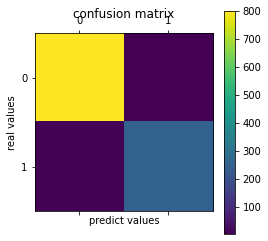

In [ ]:
# In[2]Binary classification index
# predictions and y_test
confusion_matrix = confusion_matrix(y_test,predictions)
print('confusion_matrix :')
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title("confusion matrix")
plt.colorbar()
plt.ylabel("real values")
plt.xlabel("predict values")
plt.show()

In [ ]:
# precision    recall  f1-score   support

print(classification_report(y_test,predictions))

# accuracy 
scores =  cross_val_score(LR,X_train,y_train,cv=5)
print("accuracy: ",scores)
print("average accuracy: ",np.mean(scores))

# Labels must be converted to numeric values

class_le = LabelEncoder()
y_train_n = class_le.fit_transform(y_train)
y_test_n = class_le.fit_transform(y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       805
           1       0.98      0.97      0.98       260

    accuracy                           0.99      1065
   macro avg       0.99      0.98      0.98      1065
weighted avg       0.99      0.99      0.99      1065

accuracy:  [0.98435055 0.99061033 0.98435055 0.98591549 0.99061033]
average accuracy:  0.9871674491392801


In [ ]:
#precision
precision =  cross_val_score(LR,X_train,y_train_n,cv=5,scoring='precision')
print("average precision: ",np.mean(precision))
# recall 
recall =  cross_val_score(LR,X_train,y_train_n,cv=5,scoring='recall')
print("average recall: ",np.mean(recall))   
# F1
f1 =  cross_val_score(LR,X_train,y_train_n,cv=5,scoring='f1')
print("average F1: ",np.mean(f1))  

average precision:  0.9765534456990392
average recall:  0.9699601052542229
average F1:  0.9731366087686887


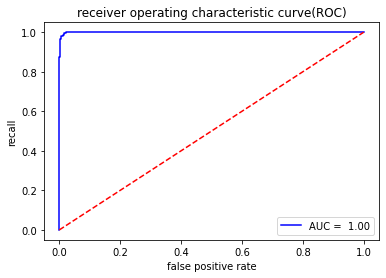

In [ ]:
#ROC curve 
predictions_pro = LR.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test_n,predictions_pro[:,1])
roc_auc = auc(false_positive_rate, recall)

plt.title("receiver operating characteristic curve(ROC)")
plt.plot(false_positive_rate, recall, 'b', label='AUC = % 0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('false positive rate')
plt.ylabel('recall')
plt.show() 

## Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer(binary=True)
vectorizer2=TfidfVectorizer(binary=True)

data_set = df['text']
X1 = vectorizer1.fit_transform(data_set)
X2 = vectorizer2.fit_transform(data_set)
y = df['spam']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.20, random_state=100)
print("the number of samples in the training data: ", X_train.shape[0])
print("the number of samples in the test data: ", X_test.shape[0])

'Both top and bottom run only one at a time'

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.20, random_state=100)
# print("the number of samples in the training data: ", X_train.shape[0])
# print("the number of samples in the test data: ", X_test.shape[0])

the number of samples in the training data:  3408
the number of samples in the test data:  852


'Both top and bottom run only one at a time'

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
clf = MultinomialNB(alpha=1, fit_prior=True)
#alpha is used for smoothing, the default is 1 
#fit_prior: whether to learn the prior probability of the class, the default is True
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("accuracy on test data: ", accuracy_score(y_test, y_pred))


accuracy on test data:  0.9823943661971831


In [ ]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y_train_n = class_le.fit_transform(y_train)
f1 =  cross_val_score(clf,X_train,y_train_n,cv=5,scoring='f1')
print("average F1: ",np.mean(f1)) 

average F1:  0.9688508455500726


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[633,   5],
       [ 10, 204]])

# TEST

In [ ]:
local_file="eval_students_2.csv"
data_set = pd.read_csv(local_file,sep=',',index_col=0,engine='python',error_bad_lines=False)
sentence = [getattr(row,'text') for row in data_set.itertuples()]
sentence_tokenized = [word_tokenize(sentence[i]) for i in range(len(sentence))]
filtered_words = [word for word in sentence_tokenized if word not in stopwords.words('english')]

new_words = []
final_words = []
for word in filtered_words:
  a = []
  for i in range(len(word)):
    if word[i].isalnum():
      a.append(word[i])
  new_words.append(a) 
df = pd.DataFrame(columns=['text'])
for word in new_words:
  str_words = ','.join(word)
  df = df.append([{'text':str_words}],ignore_index=True)

X_X = df['text'].values
X_TEST= vectorizer.transform(X_X)
predictions = LR.predict(X_TEST)

In [ ]:
import csv
import numpy as np
b = open('output4.csv', 'w')
a = csv.writer(b)
data = predictions
a.writerows(data)
b.close()